In [49]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.stats import shapiro, skew
from scipy.cluster.hierarchy import dendrogram, linkage
from joblib import Memory
from textwrap import fill


In [40]:
DEFAULT_CRS = "EPSG:4326"
RANDOM_STATE = 42

In [5]:
dados = gpd.read_file('data/WGS84_hex_agg.gpkg')

In [45]:
col_dic = { 
    "qnt_unidades_sum": "Soma quantidade de Unidades IPTU",
    "qnt_unidades_mean": "Média quantidade de Unidades IPTU",
    "qnt_unidades_median": "Mediana quantidade de Unidades IPTU",
    "qnt_unidades_std": "Desvio Padrão quantidade de Unidades IPTU",
    "qnt_unidades_var": "Variância quantidade de Unidades IPTU",
    "area_sum": "Soma da área de construção Open Buildings",
    "area_mean": "Média da área de construção Open Buildings",
    "area_median": "Mediana da área de construção Open Buildings",
    "area_var": "Variância Soma da área de construção Open Buildings",
    "area_std": "Desvio Padrão Soma da área de construção Open Buildings",
    "area_count": "Quantidade de construção Open Buildings",
    "D1_012_d_sum": "Quantidade de domicílios com acesso à rede de água da rede geral CENSO 2010",
    "D1_017_d_sum": "Quantidade de domicílios com acesso à rede de esgoto geral CENSO 2010",
    "D1_035_d_sum": "Quantidade de domicílios com lixo coletado CENSO 2010",
    "D1_044_d_sum": "Quantidade de domicílios com energia elétrica de companhia distribuidora CENSO 2010",
    "esp_1": "Quantidade de Residenciais CNEFE 2022" 
}


In [46]:
df = dados[col_dic.keys()]

In [14]:
print(list(df.columns))

['qnt_unidades_sum', 'qnt_unidades_mean', 'qnt_unidades_median', 'qnt_unidades_std', 'qnt_unidades_var', 'area_sum', 'area_mean', 'area_median', 'area_var', 'area_count', 'D1_012_d_sum', 'D1_017_d_sum', 'D1_035_d_sum', 'D1_044_d_sum']


## Olhar as distribuições das variaiveis

In [21]:
# Função para plotar o gridplot de histogramas e testar a normalidade e skewness
def plot_distributions_and_tests(df):
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()  # Selecionar apenas colunas numéricas
    n_cols = 3  # Definir o número de colunas no grid
    n_rows = int(np.ceil(len(num_cols) / n_cols))  # Definir o número de linhas com base no número de colunas
    
    # Criar o gridplot
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
    axes = axes.flatten()  # Flatten a matriz de eixos para acessar individualmente
    
    for i, col in enumerate(num_cols):
        sns.histplot(df[col], bins=30, kde=True, ax=axes[i])  # Gerar histograma com KDE (Kernel Density Estimate)
        title = fill(f'Histograma de {col_dic[col]}', width=40)
        axes[i].set_title(title)
        
        # Teste de normalidade Shapiro-Wilk
        stat, p_value = shapiro(df[col].dropna())  # Descartar valores nulos
        normality = "Normal" if p_value > 0.05 else "Não Normal"
        
        # Cálculo de skewness
        skewness_val = skew(df[col].dropna())
        skewness_type = "Positiva" if skewness_val > 0 else "Negativa"
        
        # Mostrar resultados no título do plot
        axes[i].set_xlabel(f'Skewness: {skewness_val:.2f} ({skewness_type})\nTeste Shapiro: p={p_value:.3f} ({normality})')

    # Remover gráficos em branco, se houver
    for j in range(i + 1, n_rows * n_cols):
        fig.delaxes(axes[j])

    # Ajustar layout
    plt.tight_layout()
    plt.show()

# Exemplo de uso
# Supondo que você tenha um DataFrame 'df'
# plot_distributions_and_tests(df)

/opt/anaconda3/envs/scriptsMestrado/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 105505.
  res = hypotest_fun_out(*samples, **kwds)
/opt/anaconda3/envs/scriptsMestrado/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 105505.
  res = hypotest_fun_out(*samples, **kwds)
/opt/anaconda3/envs/scriptsMestrado/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 105505.
  res = hypotest_fun_out(*samples, **kwds)
/opt/anaconda3/envs/scriptsMestrado/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 105505.
  res = hypotest_fun_out(*samples, 

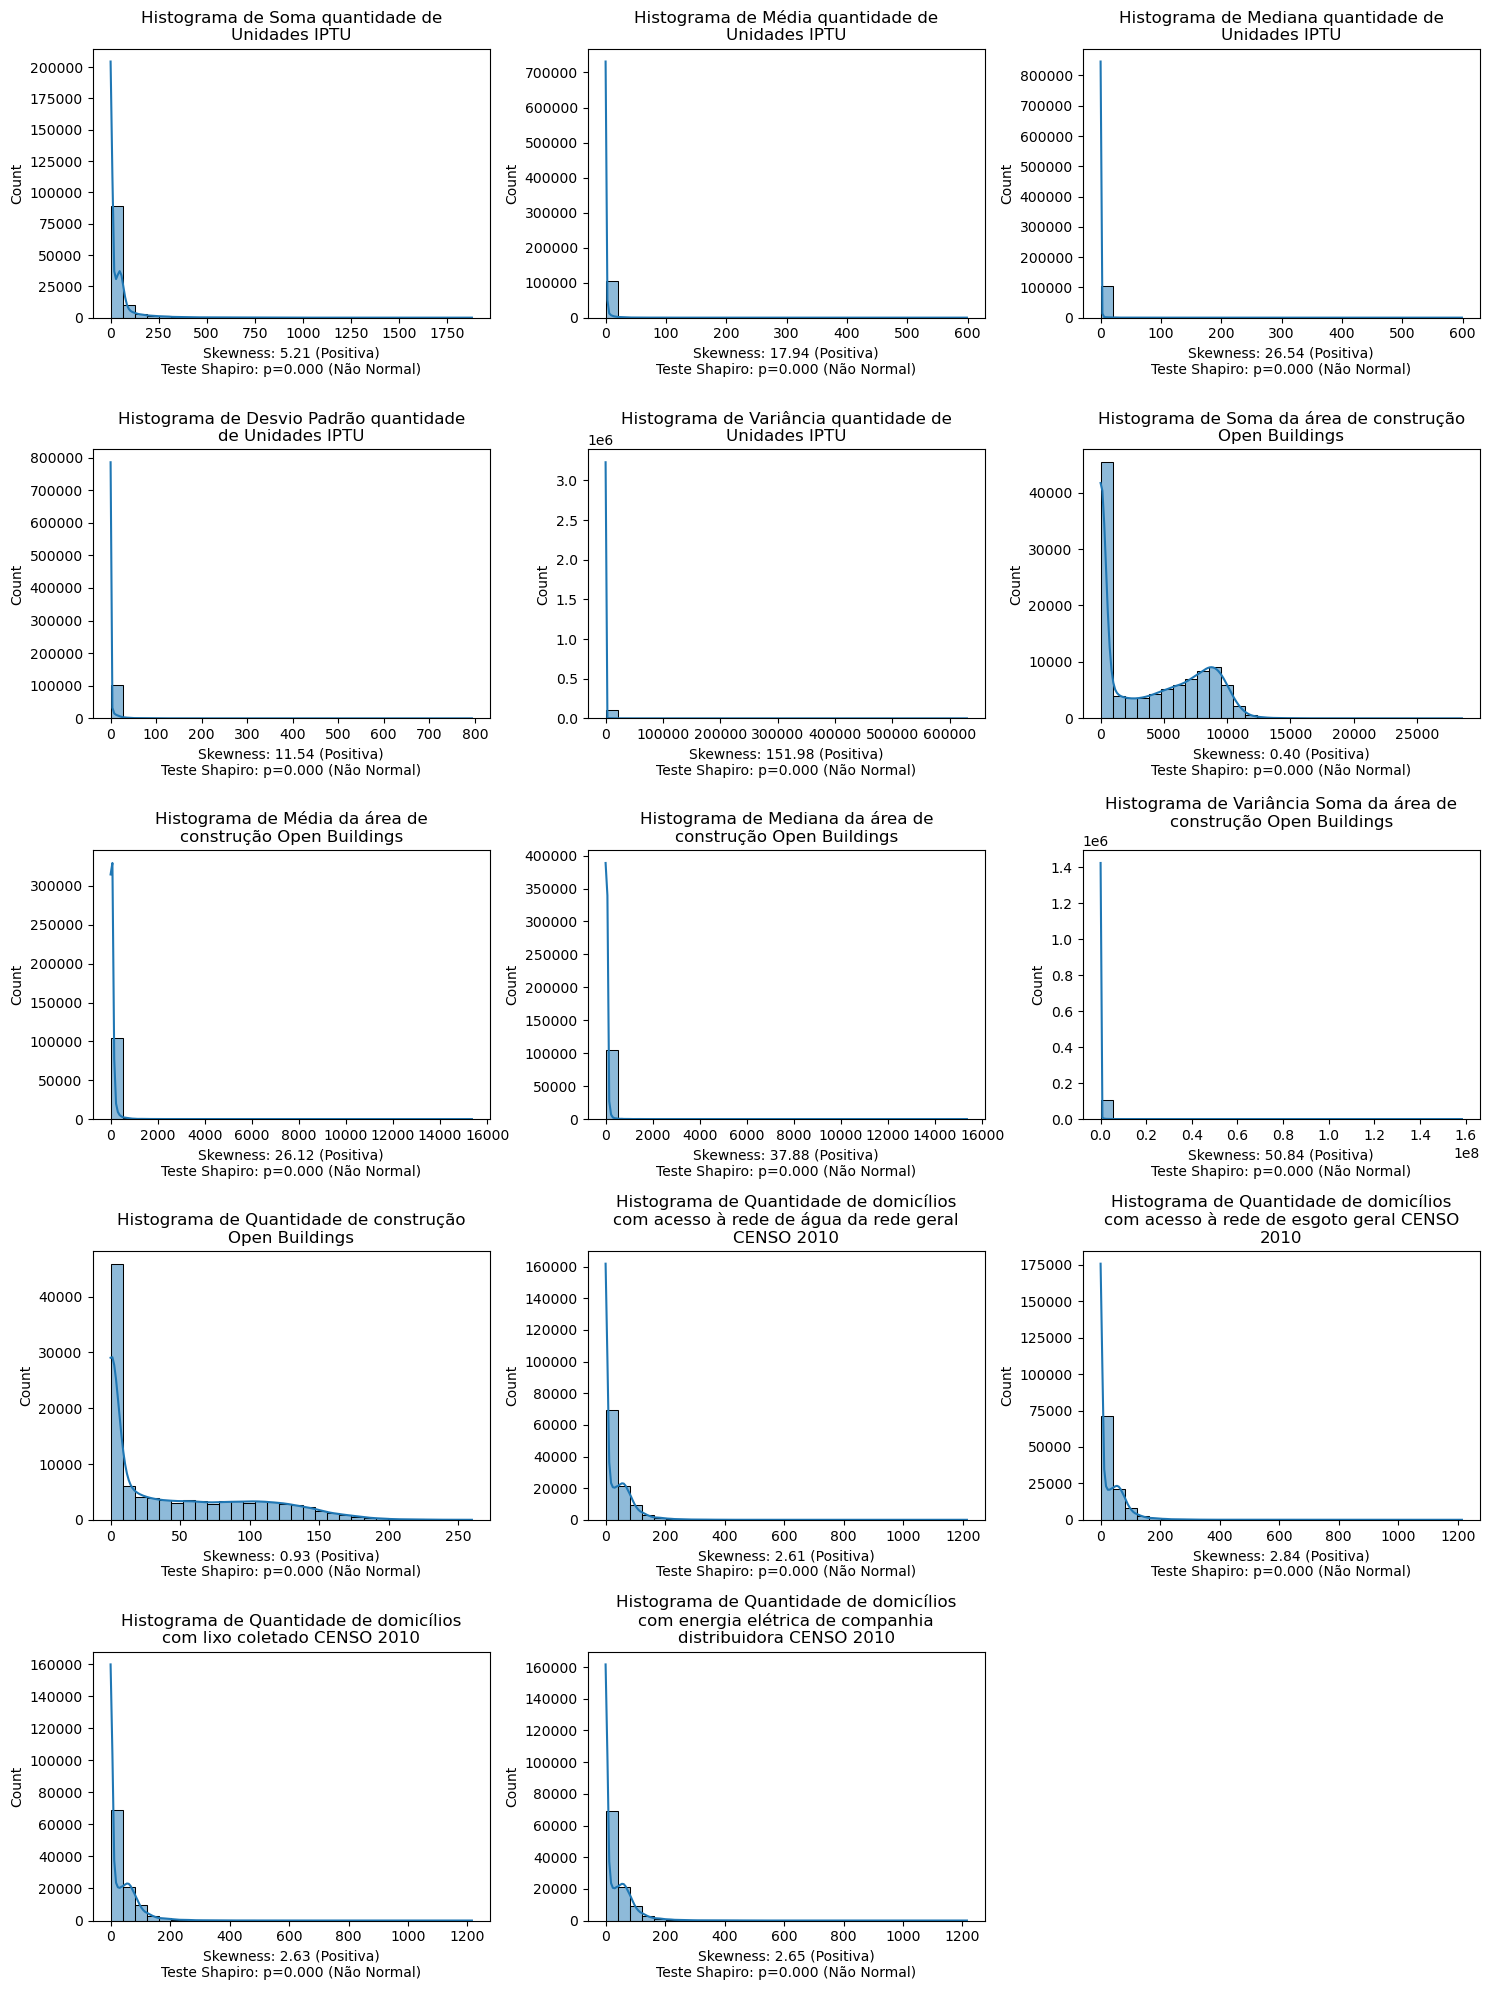

In [22]:
plot_distributions_and_tests(df)

### Analise das Distribuições 
- Nenhum dado é normal 
- Todos tem Skewness positivo -> utilizar Spearman's rank correlation
- Tem uma grande concentração com Zeros, não tem como aplicar log para normalizar

## Testar com dados em log

### Analise

Os dados em log, tem distribuição normal e sem skeness

## Correlação

In [24]:
# Função para calcular a correlação e criar o gráfico
def plot_correlation(df, method="pearson"):
    # Calcular a correlação de Spearman
    corr_matrix = df.corr(method=method)

    # Criar uma máscara para a parte superior da matriz
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Criar um mapa de cores para o gráfico
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Configurar a figura
    plt.figure(figsize=(10, 8))

    # Plotar o mapa de calor da correlação com Seaborn
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .8})

    # Adicionar título
    plt.title(f"{method}'s Correlation", fontsize=16)
    
    # Mostrar o gráfico
    plt.show()

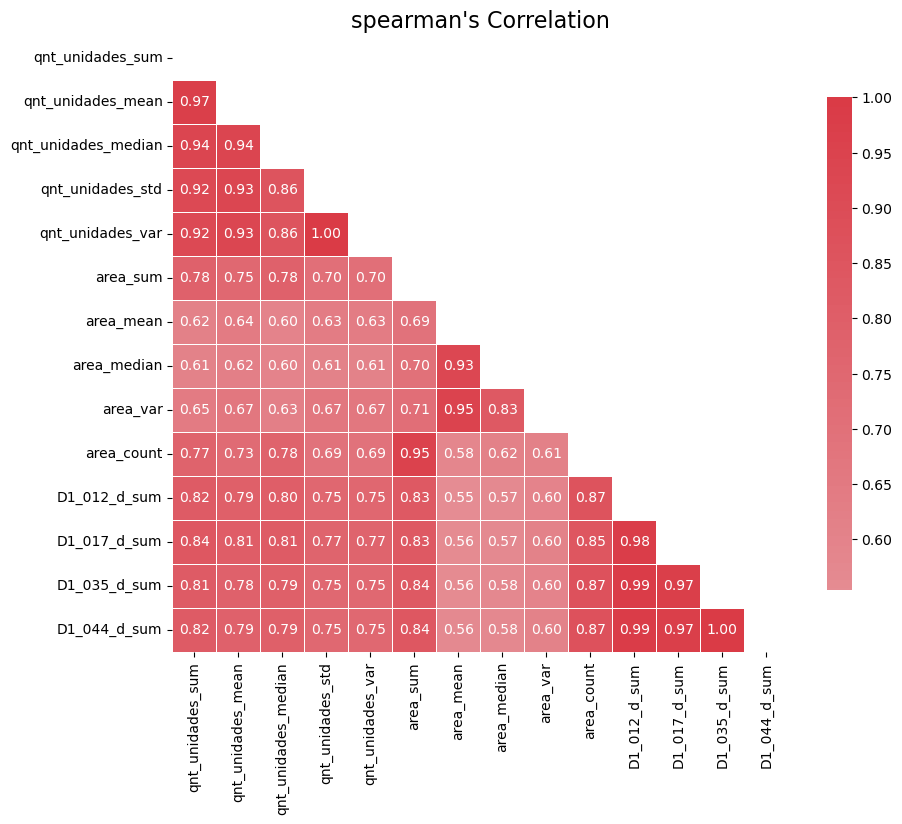

In [25]:
plot_correlation(df, 'spearman')

# Analise dos dados indices para identificação de Assentamentos Precários
- Índice de regularidade fundiária dos endereços residenciais
    - CNEFE: Apenas domicílios particulares
    - IPTU: Apenas lançamentos com uso residencial
- Indices de infraestrutura urbana


In [53]:
# Função para aplicar K-means e plotar o coeficiente de silhueta
def find_best_kmeans(data, k_range=(2, 10)):
    # Padronizar os dados para melhorar o desempenho do K-means
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    
    # Armazenar os resultados
    silhouette_scores = []
    k_values = list(range(k_range[0], k_range[1] + 1))
    
    # Testar diferentes valores de K
    for k in k_values:
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=RANDOM_STATE, init="random", n_init=1000)
        # use minibatch because of the peformance
        cluster_labels = kmeans.fit_predict(scaled_data)
        silhouette_avg = silhouette_score(scaled_data, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    
    # Plotar o coeficiente de silhueta
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, silhouette_scores, 'bo-', color='blue', marker='o', label='Silhouette Score')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Silhouette Coefficient')
    plt.title('Silhouette Coefficient for different values of K')
    plt.xticks(k_values)
    plt.grid(True)
    plt.show()
    
    # Escolher o melhor valor de K (máximo coeficiente de silhueta)
    best_k = k_values[np.argmax(silhouette_scores)]
    print(f"Best K: {best_k} with Silhouette Coefficient: {max(silhouette_scores)}")
    
    # Treinar o KMeans com o melhor K
    best_kmeans = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, init="random", n_init=1000)
    #using kmeans because the results are litter better
    best_kmeans.fit(scaled_data)
    
    # Retornar os centróides e rótulos do cluster
    centroids = scaler.inverse_transform(best_kmeans.cluster_centers_)  # Desescalonar para os valores originais
    return best_k, centroids, best_kmeans.labels_

## Analise de cluster por Regularidade Fundiária

In [47]:
regul_fun = ["qnt_unidades_sum", "esp_1"]

/var/folders/kf/12t4yv8j7pg0z8zqbypmj9440000gn/T/ipykernel_74518/1800989486.py:21: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(k_values, silhouette_scores, 'bo-', color='blue', marker='o', label='Silhouette Score')
/var/folders/kf/12t4yv8j7pg0z8zqbypmj9440000gn/T/ipykernel_74518/1800989486.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(k_values, silhouette_scores, 'bo-', color='blue', marker='o', label='Silhouette Score')


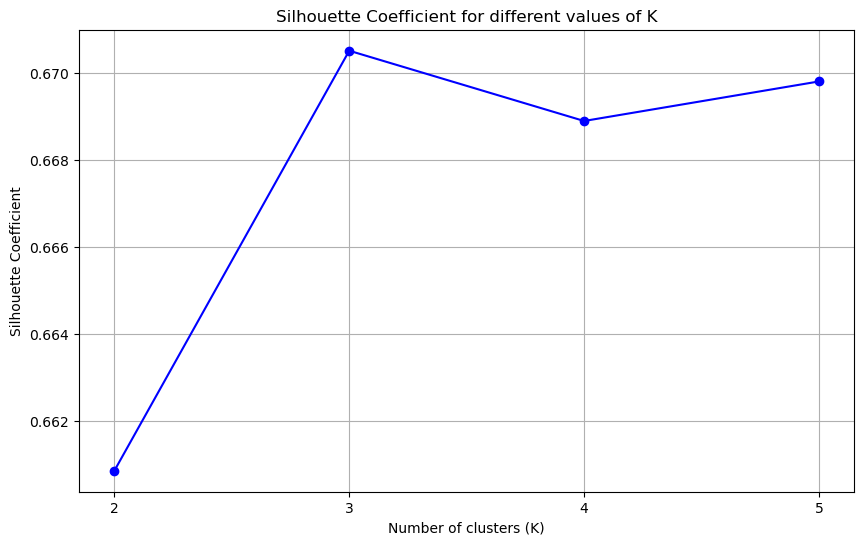

Best K: 3 with Silhouette Coefficient: 0.6705068691111918


In [55]:
best_k, centroids, labels = find_best_kmeans(df[regul_fun], k_range=(2, 5))

### Visulizar do cluster com melhor métrica

In [56]:
regul_fun_cluster_df = pd.concat(
         [df[regul_fun], dados['geometry'], pd.DataFrame(labels, columns=["cluster"])],
          axis=1)

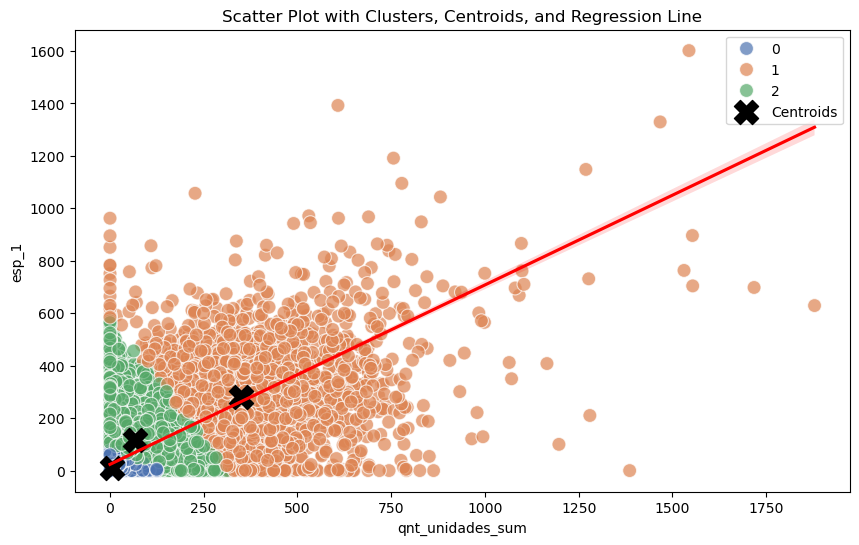

In [57]:

# Plot the scatter plot
plt.figure(figsize=(10, 6))

# Scatter plot of points, colored by cluster
sns.scatterplot(data=regul_fun_cluster_df, x="qnt_unidades_sum", y='esp_1', hue='cluster', palette='deep', s=100, alpha=0.7)
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='black', marker='X', label='Centroids')
sns.regplot(data=regul_fun_cluster_df,x="qnt_unidades_sum", y='esp_1', scatter=False, color='red', line_kws={"label": "Regression Line"})

# Add titles and labels
plt.title('Scatter Plot with Clusters, Centroids, and Regression Line')
plt.legend()
plt.show()

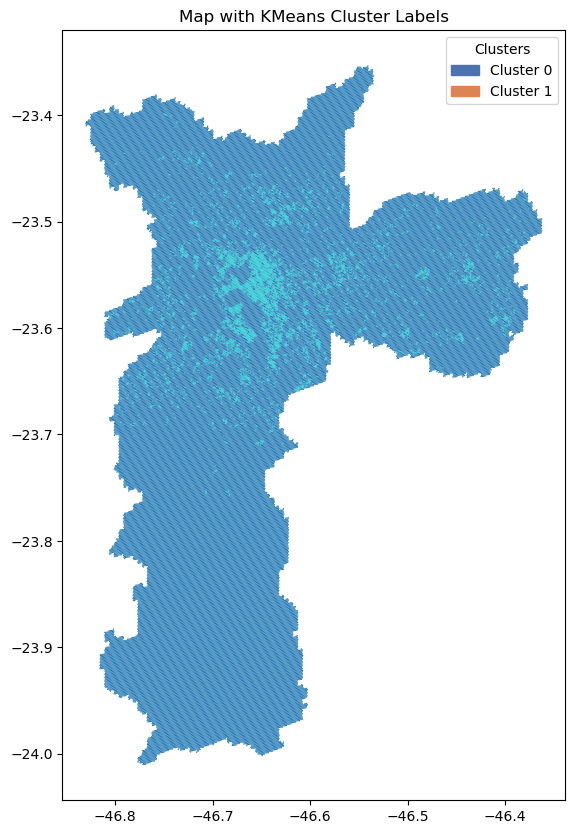

In [59]:
# Use the same color palette as in the scatter plot
palette = sns.color_palette('deep', n_colors=len(regul_fun_cluster_df['cluster'].unique()))

# Map cluster labels to colors
regul_fun_cluster_df['color'] = regul_fun_cluster_df['cluster'].map(dict(zip(range(len(palette)), palette)))

fig, ax = plt.subplots(figsize=(10, 10))
(gpd.
 GeoDataFrame(
    regul_fun_cluster_df,
       geometry="geometry",
       crs=DEFAULT_CRS)
 ).plot(ax=ax, column="color")

#Create the legend with cluster numbers
legend_labels = [mpatches.Patch(color=palette[i], label=f'Cluster {i}') for i in range(len(palette))]
plt.legend(handles=legend_labels, title="Clusters", loc='upper right')

# Add titles and labels
plt.title('Map with KMeans Cluster Labels')
plt.show()

In [58]:
print(f"Centróides para o melhor K={best_k}:\n", centroids)

Centróides para o melhor K=3:
 [[  6.5006104    7.97132048]
 [349.11587393 279.86049273]
 [ 66.06553585 114.94913685]]


In [84]:
pd.DataFrame(centroids, columns=df[regul_fun].columns)

,qnt_unidades_sum,esp_1
0,6.500610,7.971320
1,349.115874,279.860493
2,66.065536,114.949137


### Adicionar cluster nos dataframe

In [60]:
dados['cluster_regularidade_fundiaria'] = labels
cluster_regularidade_fundiaria_centroids = centroids

# Analise dos dados indices de infraestrutura urbana
- Dados censitários:
    - percentual de domicílios com acesso à rede de água da rede geral (D1_012)
    - à rede de esgoto geral (D1_017)- 
    - com lixo coletado (D1_035), 
    - com energia elétrica de companhia distribuidora (D1_044))



In [26]:
infra_urban_var = ['D1_012_d_sum', "D1_017_d_sum", "D1_035_d_sum", "D1_044_d_sum"]

In [27]:
df[infra_urban_var].head()

,D1_012_d_sum,D1_017_d_sum,D1_035_d_sum,D1_044_d_sum
0,122.0,122.0,122.0,122.0
1,97.0,97.0,97.0,96.0
2,64.0,64.0,64.0,64.0
3,249.0,248.0,249.0,248.0
4,0.0,0.0,0.0,0.0


/var/folders/kf/12t4yv8j7pg0z8zqbypmj9440000gn/T/ipykernel_74518/1800989486.py:21: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(k_values, silhouette_scores, 'bo-', color='blue', marker='o', label='Silhouette Score')
/var/folders/kf/12t4yv8j7pg0z8zqbypmj9440000gn/T/ipykernel_74518/1800989486.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(k_values, silhouette_scores, 'bo-', color='blue', marker='o', label='Silhouette Score')


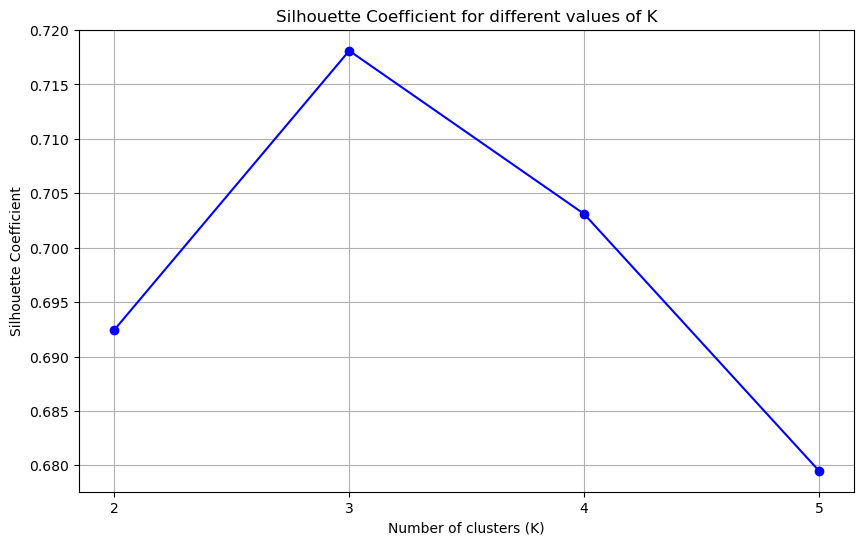

Best K: 3 with Silhouette Coefficient: 0.7181035444634145


In [61]:
best_k, best_centroids, best_labels = find_best_kmeans(df[infra_urban_var], k_range=(2, 5))

In [33]:
infra_urban_best_df = pd.concat(
         [df[infra_urban_var], dados['geometry'], pd.DataFrame(best_labels, columns=["cluster"])],
          axis=1)

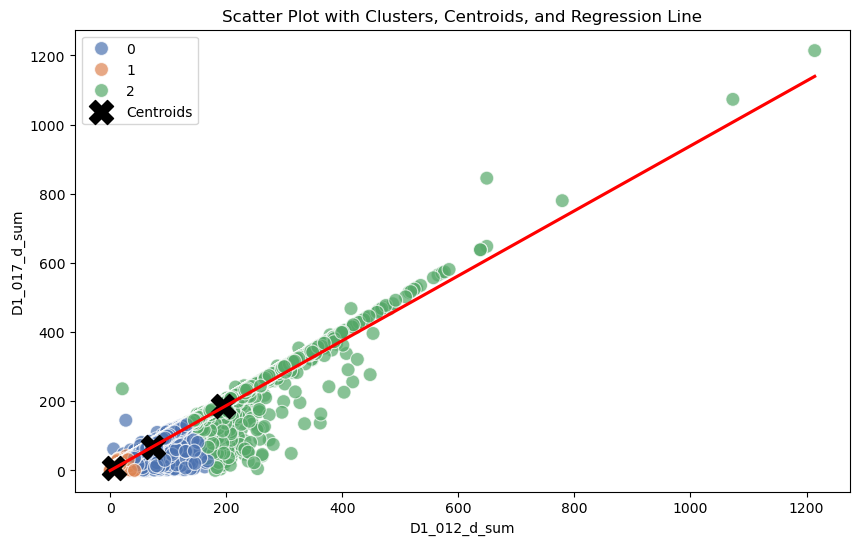

In [36]:
# Plot the scatter plot
plt.figure(figsize=(10, 6))

# Scatter plot of points, colored by cluster
sns.scatterplot(data=infra_urban_best_df, x="D1_012_d_sum", y='D1_017_d_sum', hue='cluster', palette='deep', s=100, alpha=0.7)
plt.scatter(best_centroids[:, 0], best_centroids[:, 1], s=300, c='black', marker='X', label='Centroids')
sns.regplot(data=infra_urban_best_df,x="D1_012_d_sum", y='D1_017_d_sum', scatter=False, color='red', line_kws={"label": "Regression Line"})

# Add titles and labels
plt.title('Scatter Plot with Clusters, Centroids, and Regression Line')
plt.legend()
plt.show()

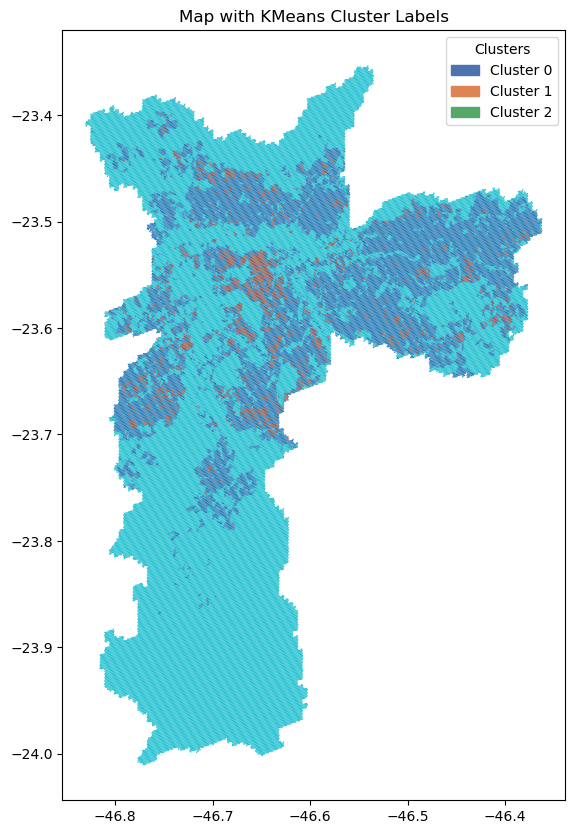

In [24]:
# Use the same color palette as in the scatter plot
palette = sns.color_palette('deep', n_colors=len(infra_urban_best_df['cluster'].unique()))

# Map cluster labels to colors
infra_urban_best_df['color'] = infra_urban_best_df['cluster'].map(dict(zip(range(len(palette)), palette)))

fig, ax = plt.subplots(figsize=(10, 10))
(gpd.
 GeoDataFrame(
    infra_urban_best_df,
       geometry="geometry",
       crs=DEFAULT_CRS)
 ).plot(ax=ax, column="color")

#Create the legend with cluster numbers
legend_labels = [mpatches.Patch(color=palette[i], label=f'Cluster {i}') for i in range(len(palette))]
plt.legend(handles=legend_labels, title="Clusters", loc='upper right')

# Add titles and labels
plt.title('Map with KMeans Cluster Labels')
plt.show()

In [83]:
pd.DataFrame(best_centroids, columns=df[infra_urban_var].columns)

,D1_012_d_sum,D1_017_d_sum,D1_035_d_sum,D1_044_d_sum
0,73.324471,68.129073,73.590330,72.951182
1,193.857417,184.302928,194.118819,192.639462
2,6.634600,5.701065,6.852079,6.703985


In [62]:
dados['cluster_infraestrutura_urbana'] = best_labels
cluster_infraestrutura_urbana_centroids = best_centroids


# Analise dos dados indices de ambiente construído
- Open Buildings Dataset: 
    - Qnt de construções: area_count
    - Tamanho médio: area_mean
    - desvio padrão: area_std



In [63]:
ambiente_construído_var = ['area_count', "area_mean", "area_std"]
df[ambiente_construído_var].head()

,area_count,area_mean,area_std
0,63.0,147.878013,156.286531
1,103.0,80.865535,70.215211
2,26.0,90.313326,74.175720
3,174.0,60.442236,54.715864
4,0.0,0.000000,0.000000


/var/folders/kf/12t4yv8j7pg0z8zqbypmj9440000gn/T/ipykernel_74518/1800989486.py:21: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(k_values, silhouette_scores, 'bo-', color='blue', marker='o', label='Silhouette Score')
/var/folders/kf/12t4yv8j7pg0z8zqbypmj9440000gn/T/ipykernel_74518/1800989486.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(k_values, silhouette_scores, 'bo-', color='blue', marker='o', label='Silhouette Score')


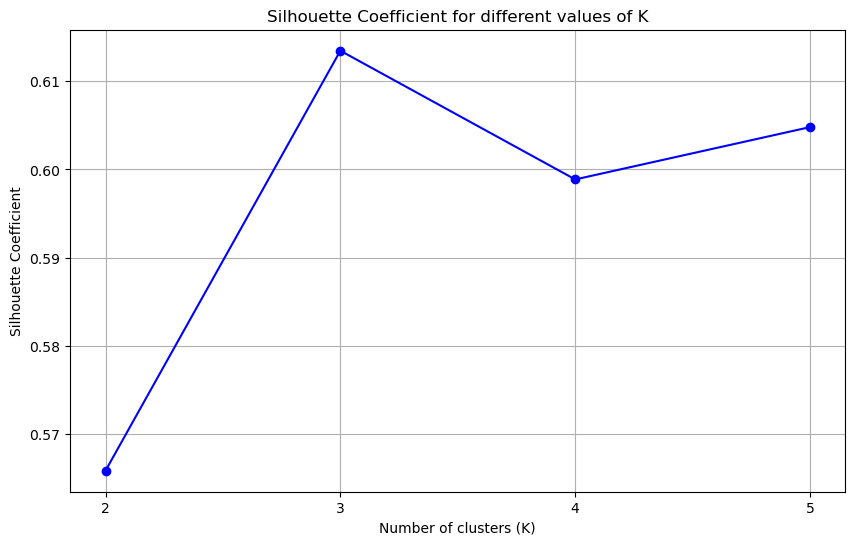

Best K: 3 with Silhouette Coefficient: 0.6134678688160247


In [64]:
best_k_ambiente_construído, best_centroids_ambiente_construído, best_labels_ambiente_construído = find_best_kmeans(df[ambiente_construído_var], k_range=(2, 5))

In [82]:
pd.DataFrame(best_centroids_ambiente_construído, columns=df[ambiente_construído_var].columns)

,area_count,area_mean,area_std
0,112.446682,77.157125,78.417016
1,12.047971,74.195111,93.299810
2,5.619744,2436.941187,2891.262341


In [65]:
dados['cluster_ambiente_construído'] = best_labels_ambiente_construído
cluster_ambiente_construído_centroids = best_centroids_ambiente_construído


# Geral

/var/folders/kf/12t4yv8j7pg0z8zqbypmj9440000gn/T/ipykernel_74518/1800989486.py:21: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(k_values, silhouette_scores, 'bo-', color='blue', marker='o', label='Silhouette Score')
/var/folders/kf/12t4yv8j7pg0z8zqbypmj9440000gn/T/ipykernel_74518/1800989486.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(k_values, silhouette_scores, 'bo-', color='blue', marker='o', label='Silhouette Score')


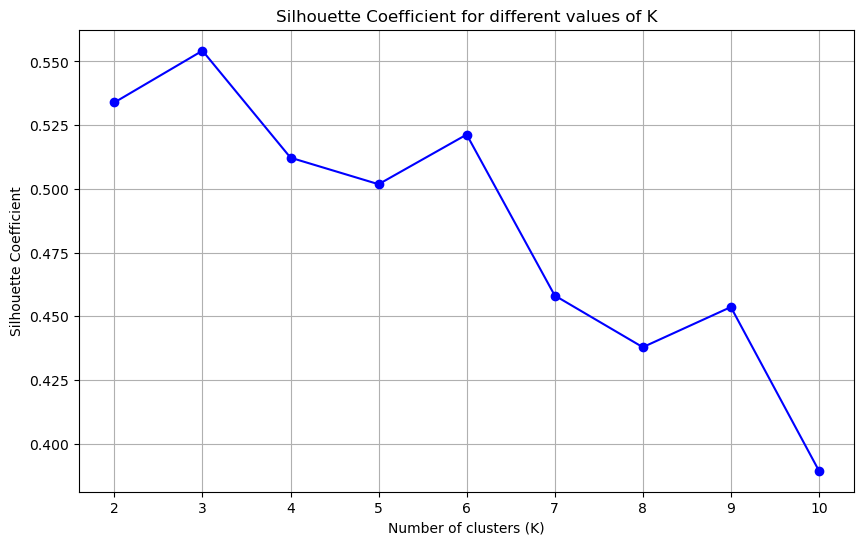

Best K: 3 with Silhouette Coefficient: 0.5542109480350642


In [70]:
# Definir intervalo de K (de 2 a 10 por exemplo)
best_k_all, centroids_all, labels_all = find_best_kmeans(df, k_range=(2, 10))


In [71]:
dados['cluster_all'] = labels_all
cluster_all_centroids = centroids_all

In [73]:
#Exibir os centróides para cada cluster
print(f"Centróides para o melhor K={best_k}:\n", centroids_all)

Centróides para o melhor K=3:
 [[4.31908100e+00 3.57412438e-01 2.21377357e-01 5.15272351e-01
  1.14189729e+01 1.33876275e+03 8.12407951e+01 4.69623768e+01
  1.35226654e+05 1.02055804e+02 1.03773932e+01 5.39223638e+00
  4.60997694e+00 5.59527310e+00 5.46586389e+00 5.54094631e+00]
 [3.35219859e+02 3.27287082e+01 1.65535930e+01 4.94187497e+01
  4.27547550e+03 5.17019087e+03 1.52947736e+02 9.71829530e+01
  6.40023530e+04 1.75609500e+02 4.31674252e+01 1.61481795e+02
  1.59630689e+02 1.61873212e+02 1.61398895e+02 2.62566320e+02]
 [6.16354878e+01 1.50798119e+00 9.50353809e-01 3.12236041e+00
  5.38464295e+01 8.00922988e+03 9.26300713e+01 6.40633746e+01
  2.98013965e+04 9.85310552e+01 1.03913591e+02 7.34953728e+01
  6.78043628e+01 7.37693548e+01 7.30516658e+01 1.01167504e+02]]


In [81]:
pd.DataFrame(centroids_all, columns=df.columns)

,qnt_unidades_sum,qnt_unidades_mean,qnt_unidades_median,qnt_unidades_std,qnt_unidades_var,area_sum,area_mean,area_median,area_var,area_std,area_count,D1_012_d_sum,D1_017_d_sum,D1_035_d_sum,D1_044_d_sum,esp_1
0,4.319081,0.357412,0.221377,0.515272,11.418973,1338.762752,81.240795,46.962377,135226.654146,102.055804,10.377393,5.392236,4.609977,5.595273,5.465864,5.540946
1,335.219859,32.728708,16.553593,49.418750,4275.475499,5170.190866,152.947736,97.182953,64002.352970,175.609500,43.167425,161.481795,159.630689,161.873212,161.398895,262.566320
2,61.635488,1.507981,0.950354,3.122360,53.846430,8009.229880,92.630071,64.063375,29801.396496,98.531055,103.913591,73.495373,67.804363,73.769355,73.051666,101.167504


In [74]:
dados.head()

,id_hex,qnt_unidades_sum,qnt_unidades_mean,qnt_unidades_median,qnt_unidades_std,qnt_unidades_var,area_sum,area_mean,area_median,area_std,...,D1_017_d_sum,D1_035_d_sum,D1_044_d_sum,CL,CATEGORIES,geometry,cluster_regularidade_fundiaria,cluster_infraestrutura_urbana,cluster_ambiente_construído,cluster_all
0,8aa8100c3257fff,187.921324,3.545685,1.000000,6.992005,48.888136,9316.314802,147.878013,90.353599,156.286531,...,122.0,122.0,122.0,2,2,"POLYGON ((-46.63592 -23.53032, -46.63664 -23.5...",2,0,0,2
1,8aa8100d2447fff,110.909650,1.440385,0.850019,6.770837,45.844233,8329.150087,80.865535,61.867680,70.215211,...,97.0,97.0,96.0,1,1,"POLYGON ((-46.53650 -23.53972, -46.53722 -23.5...",2,0,0,2
2,8aa8100e1637fff,99.565528,5.531418,0.974683,14.344737,205.771485,2348.146472,90.313326,71.872491,74.175720,...,64.0,64.0,64.0,1,1,"POLYGON ((-46.66886 -23.59437, -46.66958 -23.5...",2,0,1,2
3,8aa8100f0827fff,0.019248,0.019248,0.019248,0.000000,0.000000,10516.949009,60.442236,46.407855,54.715864,...,248.0,249.0,248.0,2,2,"POLYGON ((-46.59115 -23.61353, -46.59187 -23.6...",2,1,0,2
4,8aa81010ec07fff,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,1,1,"POLYGON ((-46.65231 -23.83331, -46.65303 -23.8...",0,2,1,0


In [75]:
dados.to_file("data/clusters.gpkg", driver="GPKG")